# Model 001
## Simple classification with deep LSTM network

* 5 min data
* Trained on 1 month of data
* Test for 1 week
    * The idea is to retrain every [1 week]?
* For right now, use a simple classification model to test whether the price $X_{t+1}$ is going to be higher, equal, or less than $X_t$
    * Ultimately, this needs to be improved so that the model considers whether the new price will exceed the spread, but that will be used in a future model
    
    
#### Some ideas for future models
* incorporate more variations on the resampling
    * for example, look at the max and min bid/ask prices over each interval to assess worst case and best case scenarios

## Step 1 -- import necessary libraries

In [53]:
from math import sin
from math import pi
from math import exp
from random import random
from random import randint
from random import uniform
from numpy import array
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.activations import softsign, relu
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpp

# 2 - Import the data from csv file

The data is saved as a csv file.  Source data file is a parameter specified below, which allows it to be defined as required (and used with papermill, if desired)

This code expects that the datafile have 3 fields - datetime, bid, ask.  The format of the datetime is specific:
YYYY MM DD HH MI SE US
where:
* YYYY: year
* MM: padded month
* DD: padded day of month
* HH: padded 24h hour of day
* MI: padded minutes
* SE: padded seconds 
* US: padded microseconds


## 2.1 Specify the path of the source data

In [54]:
src = '/var/local/foresight/timeseries/EURGBP-2016-01.pp1.xz'

### 2.1.1 Setup program parameters

In [55]:
Use_Scaler = None # [MinMaxScaler, None]
seq_len = 60 # 1 hours
num_outs = 1 # number of future outputs to forecast
sample_time = '5T' # T=minutes
Transform = 'LogDiff' # [Diff, LogDiff, None]

## 2.2 Import the data

1. Load the data into a dataframe
2. Specify the column names
3. Convert the date field into the correct datetime64 object

In [56]:
data_raw = pd.read_csv(src)
data_raw.columns = ['date', 'bid', 'ask']
data_raw['date'] = pd.to_datetime(data_raw['date'], format="%Y %m %d %H %M %S %f")
data_raw.set_index('date', inplace=True)

### 2.2.1 Add new field with calculated spread

In [57]:
data_raw['spread'] = data_raw['ask' ] - data_raw['bid']

In [58]:
print(data_raw[:10])

                                bid      ask   spread
date                                                 
2016-01-04 00:00:01.000353  0.73643  0.73651  0.00008
2016-01-04 00:00:01.000471  0.73641  0.73651  0.00010
2016-01-04 00:00:01.000648  0.73641  0.73652  0.00011
2016-01-04 00:00:01.000775  0.73641  0.73651  0.00010
2016-01-04 00:00:02.000429  0.73641  0.73652  0.00011
2016-01-04 00:00:02.000993  0.73643  0.73652  0.00009
2016-01-04 00:00:02.000995  0.73643  0.73651  0.00008
2016-01-04 00:00:02.000997  0.73641  0.73651  0.00010
2016-01-04 00:00:03.000198  0.73641  0.73649  0.00008
2016-01-04 00:00:04.000740  0.73641  0.73654  0.00013


### 2.2.2 Remove duplicate indices

In [59]:
df1 = data_raw[~data_raw.index.duplicated()]
print(df1.head(10))

                                bid      ask   spread
date                                                 
2016-01-04 00:00:01.000353  0.73643  0.73651  0.00008
2016-01-04 00:00:01.000471  0.73641  0.73651  0.00010
2016-01-04 00:00:01.000648  0.73641  0.73652  0.00011
2016-01-04 00:00:01.000775  0.73641  0.73651  0.00010
2016-01-04 00:00:02.000429  0.73641  0.73652  0.00011
2016-01-04 00:00:02.000993  0.73643  0.73652  0.00009
2016-01-04 00:00:02.000995  0.73643  0.73651  0.00008
2016-01-04 00:00:02.000997  0.73641  0.73651  0.00010
2016-01-04 00:00:03.000198  0.73641  0.73649  0.00008
2016-01-04 00:00:04.000740  0.73641  0.73654  0.00013


## 2.3 Resample the data into regular intervals

Create multiple versions of the data:
* forward fill
* ~~backward fill~~
* ~~interpolate~~
* nearest

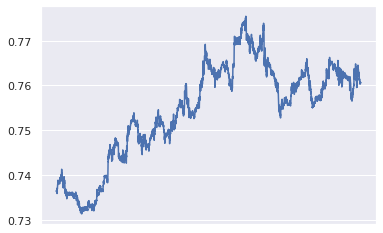

In [60]:
# resample the data, using the nearest value
df2d = df1.resample(sample_time).nearest()

# remove the weekends when there is no trading
#df2a_ = df2a[df2a.index.dayofweek < 5]
df2d_ = df2d[df2d.index.dayofweek < 5]

#print(df2a_.head(3))

import matplotlib.dates as mdates
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(24, 16)})
#ax.set_ylabel('Daily Consumption (GWh)')
#ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
ax.plot(df2d_['bid'].values);

### 2.3.1 Extract the largest spreads during each period

In [61]:
max_spreads = df1.resample('1T').max()['spread']
print(max_spreads.head(10))

date
2016-01-04 00:00:00    0.00013
2016-01-04 00:01:00    0.00013
2016-01-04 00:02:00    0.00008
2016-01-04 00:03:00    0.00009
2016-01-04 00:04:00    0.00011
2016-01-04 00:05:00    0.00011
2016-01-04 00:06:00    0.00010
2016-01-04 00:07:00    0.00011
2016-01-04 00:08:00    0.00012
2016-01-04 00:09:00    0.00011
Freq: T, Name: spread, dtype: float64


## 2.4 Transform the data 

### Prepare the transformation function

For now, the function will be defined with some minimal generality.  The arguments for the function to be passed to the model will be fixed by using `functools.partial`, since the transform function for fx.models.Model accepts only a single parameter containing the data array

Difference the data
Get absolute differences of the data.  Drop the first datum since this will necessarily be NaN

In [62]:
def data_transformer_old(data, transform = None, remove_outliers = False, scaler = 'MinMaxScaler'):
    """
    General input data transformation function
    
    :param data: Input dataset to be transformed.  This data is expected to be a 1D array of datapoints,
        already resampled and with the weekends removed from the data
    :type data: :class:`numpy.ndarray`
    
    :param transform: transformation make the data roughly stationary
    :type transform: valid values are [None, 'Diff', 'LogDiff']

    :param remove_outliers: a number denoting the number of sigmas for the cutoff or else false to indicate
        that outliers should not be removed
    :type remove_outliers: `integer` or False
    
    :param scaler: the type of scaler to use for the data to change the range of values
    :type scaler: [\'MinMaxScaler\' or None ]
    """

    assert(len(data.shape) == 1) # The data should only be a 1D array, with the datetime stripped off

    # difference the data. numpy.diff automatically trims off the leading nan
    if transform == 'Diff':
        data_ = np.diff(data)
    elif transform == 'LogDiff':
        data_ = np.diff(np.log(data))
    elif transform == None:
        pass
    else:
        raise ValueError('transform must be either \'Diff\', \'LogDiff\', or None')
    
    # optionally remove outliers. If the value of the parameter passed is not False (or equivilent), replace outlying data
    # with backfilled data - i.e. replace the outlier with the next valid value
    if Remove_Outliers:
        data_[np.abs(ddf2d.bid-ddf2d.bid.mean()) > (2*ddf2d.bid.std())] = np.nan
        data_ = pd.Series(data_).fillna(method='bfill').to_numpy()

    if Use_Scaler == 'MinMaxScaler':
        scaler = skpp.MinMaxScaler((-1,1))
        data_ = scaler.fit_transform(data_)

    return data_, scaler

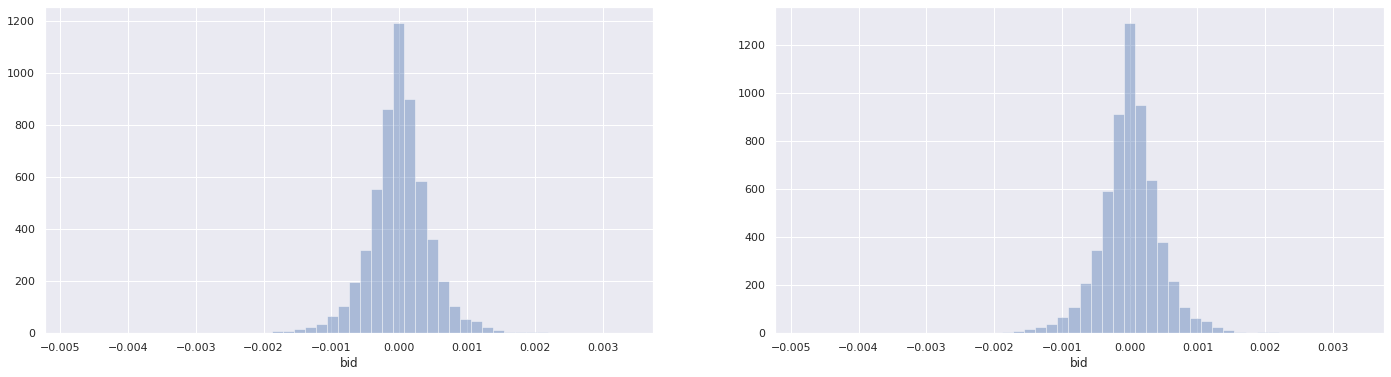

In [134]:
#sns.distplot(ddf2a['bid'], kde=False, rug=False)
sns.set(rc={'figure.figsize':(24, 6)})
fig, axes = plt.subplots(1,2)
sns.distplot(ddf2d['bid'], kde=False, rug=False, ax=axes[0], label='ddf2d');
sns.distplot(ddf2a['bid'], kde=False, rug=False, ax=axes[1], norm_hist=True);

### 2.4.1 Optionally, remove outliers

In [27]:
Remove_Outliers = True

In [28]:
print(ddf2d.bid.std())
if Remove_Outliers:
    ddf2d = ddf2d[np.abs(ddf2d.bid-ddf2d.bid.mean()) <= (2*ddf2d.bid.std())]
#    pass
print(ddf2d.shape)
print(ddf2d[np.abs(ddf2d.bid-ddf2d.bid.mean()) <= (2*ddf2d.bid.std())].shape)

0.00046662218994687825
(5409, 3)
(5095, 3)


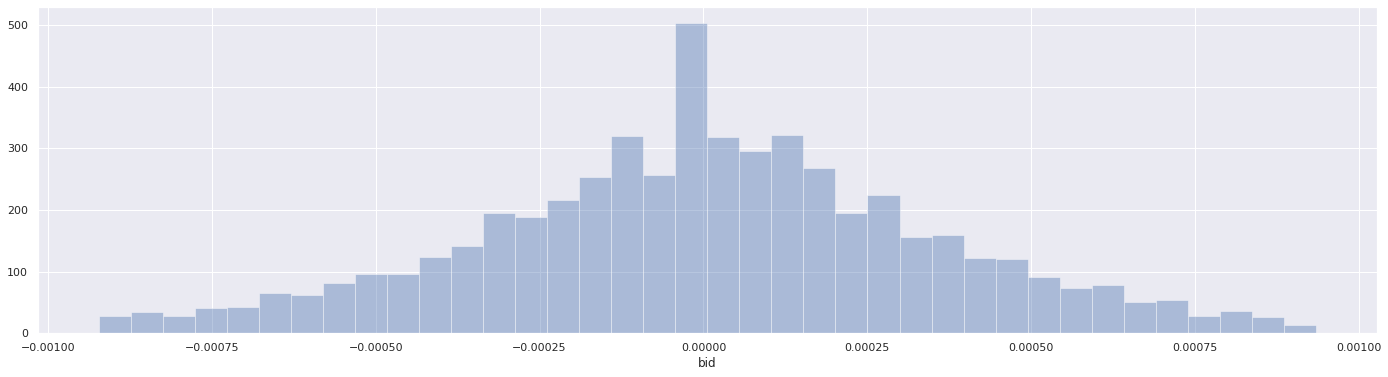

In [153]:
#sns.distplot(ddf2a['bid'], kde=False, rug=False)
sns.set(rc={'figure.figsize':(24, 6)})
fig, axes = plt.subplots(1,1)
sns.distplot(ddf2d['bid'], kde=False, rug=False, ax=axes, label='ddf2d');
#sns.distplot(ddf2a['bid'], kde=False, rug=False, ax=axes[1], norm_hist=True);

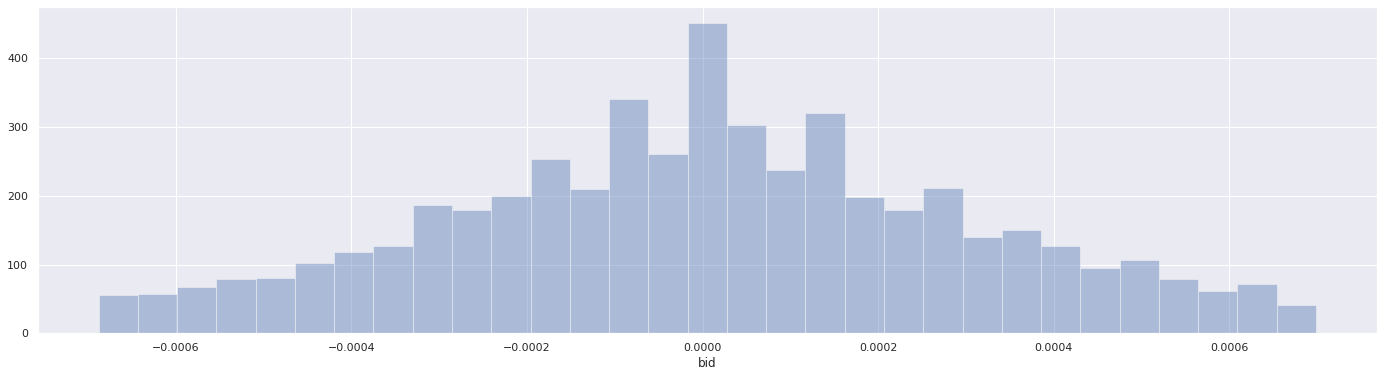

In [29]:
#sns.distplot(ddf2a['bid'], kde=False, rug=False)
sns.set(rc={'figure.figsize':(24, 6)})
fig, axes = plt.subplots(1,1)
sns.distplot(ddf2d[np.abs(ddf2d.bid-ddf2d.bid.mean()) <= (2*ddf2d.bid.std())]['bid'], kde=False, rug=False, ax=axes, label='ddf2d');
#sns.distplot(ddf2a['bid'], kde=False, rug=False, ax=axes[1], norm_hist=True);

## 2.5 Setup the model inputs and outputs
Convert the data into numpy arrays.  The outputs are the shifted bid values.

This model takes sequences of defined lengths, as noted below.  Each sequence will represent a single sample to be fed into the model.  For right now, for simplicity, the sequences will not be overlapping.  This should be addressed in a future revision of the model.

In [154]:

data_length = ddf2d.shape[0]

# Define a function that rounds a value down to the nearest base value
# e.g. round_down(x = 124.183, base = 5) should return 120
def round_down(x, base=5):
#    print('base ', base, 'x:', x, 'x/base', x/base, 'round(x/base)',round(x/base))
    return base * (round(x/base) - 1)

num_seqs = round_down(data_length / seq_len, base = 5)
data_to_keep = num_seqs * seq_len
print('Total number of samples: ', num_seqs, 
      '\nTruncated length of data:', data_to_keep)

Total number of samples:  85 
Truncated length of data: 5100


### 2.5.0 Scale the date to values between -1 and 1

In [155]:
Use_Scaler = 'MinMaxScaler' # [MinMaxScaler, None]
if Use_Scaler == 'MinMaxScaler':
    scaler = skpp.MinMaxScaler((-1,1))
    data_scaler = scaler.fit(ddf2d)
    scaled_data = pd.DataFrame(data_scaler.transform(ddf2d), columns=ddf2d.columns, index=ddf2d.index)
else:
    scaled_data = ddf2d

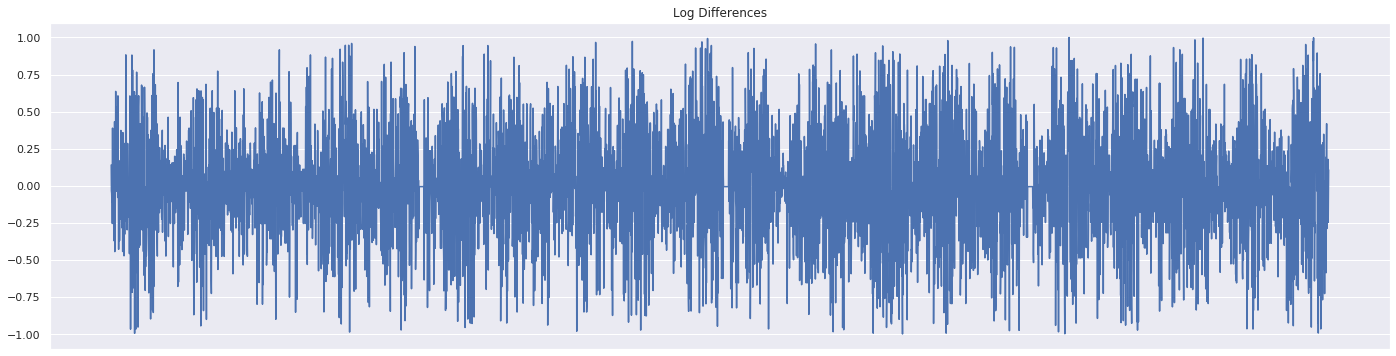

In [156]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.set_title('Log Differences')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
ax.plot(scaled_data['bid'].values);



### 2.5.1 Define a function to manipulate the data into input and output series

In [157]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, separate_output_series=False):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars =  1 if (type(data) is list or (type(data) in [pd.DataFrame, pd.Series, np.ndarray] and len(data.shape) ==1)) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    outnames = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    if not separate_output_series:
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    else:
        
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                outnames += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                outnames += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = [*names, *outnames]
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    if separate_output_series:
        out = pd.DataFrame()
        for col in outnames:
            out[col] = agg[col]
            del agg[col]
        return agg, out
    return agg
 

In [158]:
Inputs_ = ['bid'] # ['bid', 'ask']

in_arr = scaled_data[Inputs_]
n_vars = 1 if len(in_arr.shape) == 1 else in_arr.shape[1]
#print(len(in_arr.shape))
#print(in_arr.shape)

#print(len(ddf2d['bid'].shape))
#in_arr = ddf2d#.head(data_to_keep)
#d1 = series_to_supervised(in_arr, n_in=seq_len, n_out=num_outs)
din, dout = series_to_supervised(in_arr.values, n_in=seq_len, n_out=num_outs, separate_output_series=True)
#print(in_arr.shape, type(in_arr))
#print(in_arr.values.shape, type(in_arr.values))
#print(in_arr[:10])
#print(din.shape)
#print(type(din))
#print(din[:4])
#print(dout[:4])
#print(din.values.reshape((din.shape[0],2,n_vars)))
#in_mat = d1.values.reshape((d1.shape[0],1,d1.shape[1]))
#[i %2 == 0 for i in range(0,dout.shape[1])]

#output_columns = [0,2] # only use var1 (bid price) for the output 
output_columns = [0] # only use var1 (bid price) for the output 


in_mat =       din.values.reshape((din.shape[0],seq_len,n_vars))
out_mat = pd.DataFrame( dout.values)[output_columns].values.reshape((dout.shape[0],-1))
#print(type(in_arr),type(in_mat), in_mat.shape, in_mat[0][0][0], '\n')
#print(in_mat)
#print(out_mat)
#print(in_arr[72], in_mat[1,0,0])

n_train = round_down(0.8*din.shape[0],base=1)
n_valid = round_down(1*(din.shape[0] - n_train)/3,base = 1)
in_train = in_mat[:n_train]
in_test = in_mat[n_train:-n_valid]
in_valid = in_mat[-n_valid:]
out_train = out_mat[:n_train]
out_test = out_mat[n_train:-n_valid]
out_valid = out_mat[-n_valid:]

print('Number of training samples: ', n_train)
print('Number of test samples: ', in_test.shape[0])
print('Number of validation samples: ', in_valid.shape[0])

pd.DataFrame(out_train).describe(percentiles=[.1 * x for x in range(10)])
#print('Input Data: ', in_train[:3,:10])
#print('Output Data: ', out_train[:3])

Number of training samples:  4277
Number of test samples:  715
Number of validation samples:  356


,0
count,4277.000000
mean,-0.001006
std,0.371654
min,-1.000000
0%,-1.000000
10%,-0.484573
20%,-0.294554
30.0%,-0.175919
40%,-0.077506
50%,-0.006252


# Define the model

In [171]:
Activation_Function = 'tanh' # ['tanh', 'softsign', 'relu', 'elu', 'LeakyReLU']

LSTM_model = Sequential()
#model.add(Bidirectional(LSTM(60, activation=Activation_Function, return_sequences=True), input_shape=(seq_len, n_vars), merge_mode='concat'))
#model.add(Bidirectional(LSTM(60, activation=Activation_Function, return_sequences=True), merge_mode='concat'))
#model.add(Bidirectional(LSTM(60, activation=Activation_Function, return_sequences=True), merge_mode='concat'))
#model.add(Bidirectional(LSTM(60, activation=Activation_Function, return_sequences=True), merge_mode='concat'))
#model.add(Bidirectional(LSTM(60, activation=Activation_Function, return_sequences=True), merge_mode='concat'))
#model.add(Bidirectional(LSTM(60), input_shape=(seq_len,1)))
#model.add(Bidirectional(LSTM(60, return_sequences=True),  merge_mode='concat'))
#model.add(Bidirectional(LSTM(60, return_sequences=True),  merge_mode='concat'))
#model.add(Bidirectional(LSTM(60)))
LSTM_model.add(LSTM(160, activation=Activation_Function, return_sequences=True, input_shape=(seq_len, n_vars)))
LSTM_model.add(LSTM(160, activation=Activation_Function, return_sequences=True))
LSTM_model.add(LSTM(160, activation=Activation_Function, return_sequences=True))
LSTM_model.add(LSTM(160, activation=Activation_Function, return_sequences=True))
LSTM_model.add(LSTM(160, activation=Activation_Function))
LSTM_model.add(Dense(len(output_columns)))
#model.compile(loss= 'mae' , optimizer= 'nadam' )
LSTM_model.compile(loss= 'mae' , optimizer= 'nadam' ) # 'adam'
#model.build()
print(LSTM_model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_106 (LSTM)              (None, 60, 160)           103680    
_________________________________________________________________
lstm_107 (LSTM)              (None, 60, 160)           205440    
_________________________________________________________________
lstm_108 (LSTM)              (None, 60, 160)           205440    
_________________________________________________________________
lstm_109 (LSTM)              (None, 60, 160)           205440    
_________________________________________________________________
lstm_110 (LSTM)              (None, 160)               205440    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 161       
Total params: 925,601
Trainable params: 925,601
Non-trainable params: 0
_______________________________________________

In [89]:
from foresight.data_functions import data_transformer
import foresight.model
from pandas import Timedelta as TD
import functools
import importlib
import foresight.data_functions
importlib.reload(foresight.model)
importlib.reload(foresight.data_functions)

# bind the specific arguments for the data transformation function and create a new partial function which only accepts an array for its argument
trans_func = functools.partial(data_transformer, transform = 'LogDiff', remove_outliers=2,  scaler = 'MinMaxScaler' )

print(df2d_['bid'].to_numpy().shape)
model_ = foresight.model.Model(LSTM_model, df2d_['bid'].to_numpy(), TD('5T'), seq_len = 60, data_transform=trans_func, stationary_transform='LogDiff' )

print(model_.rawdata)
print(model_.in_data[:2], '\n\n\n', model_.out_data, model_.in_data.shape, model_.out_data.shape    )

(5724,)
[0.76205 0.762   0.76146 0.76144 0.76165 0.76151 0.76112 0.76137 0.76121
 0.76122 0.76124 0.76073 0.76073 0.76063 0.76063 0.76066 0.76056 0.7607
 0.76029 0.76048 0.76078 0.76058 0.76051 0.76054 0.76051 0.7606  0.76073
 0.76056 0.76053 0.76061]
[[[ 0.13994446]
  [-0.0354903 ]
  [-0.05011069]
  [-0.10859523]
  [-0.02087368]
  [-0.25484302]
  [ 0.38854094]
  [-0.06473128]
  [-0.15246335]
  [-0.00625249]
  [ 0.05223423]
  [-0.06473922]
  [-0.00625249]
  [-0.37186652]
  [-0.35735879]
  [ 0.43207651]
  [ 0.43207651]
  [-0.4445815 ]
  [ 0.35903407]
  [-0.15235225]
  [ 0.06679986]
  [ 0.6363946 ]
  [ 0.24194028]
  [ 0.31485325]
  [ 0.09589744]
  [-0.0354372 ]
  [ 0.09589052]
  [-0.03543522]
  [-0.02084416]
  [ 0.5335073 ]]

 [[-0.0354903 ]
  [-0.05011069]
  [-0.10859523]
  [-0.02087368]
  [-0.25484302]
  [ 0.38854094]
  [-0.06473128]
  [-0.15246335]
  [-0.00625249]
  [ 0.05223423]
  [-0.06473922]
  [-0.00625249]
  [-0.37186652]
  [-0.35735879]
  [ 0.43207651]
  [ 0.43207651]
  [-0.4445

This will produce output similar to:

In [24]:
#print(ddf2a.head(3))
#print(ddf2b.head(3))
#print(ddf2c.head(3))
print(ddf2d.head(3))
print(_ddf2d[:3])

                          bid       ask    spread
date                                             
2016-01-04 00:05:00  0.000136  0.000081 -0.693147
2016-01-04 00:10:00 -0.000027  0.000000  0.405465
2016-01-04 00:15:00 -0.000041 -0.000041  0.000000
[ 1.35781013e-04 -2.71547276e-05 -4.07334741e-05]


In [189]:
# fit model
#X, y = generate_examples(length, 15000, output)
history = model.fit(in_train, out_train, batch_size=256, epochs=750, verbose=1)

Train on 4277 samples
Epoch 1/750
4277/4277 [==============================] - 2s 399us/sample - loss: 0.0089
Epoch 2/750
4277/4277 [==============================] - 2s 395us/sample - loss: 0.0092
Epoch 3/750
4277/4277 [==============================] - 2s 430us/sample - loss: 0.0091
Epoch 4/750
4277/4277 [==============================] - 2s 431us/sample - loss: 0.0088
Epoch 5/750
4277/4277 [==============================] - 2s 424us/sample - loss: 0.0089
Epoch 6/750
4277/4277 [==============================] - 2s 424us/sample - loss: 0.0088
Epoch 7/750
4277/4277 [==============================] - 2s 425us/sample - loss: 0.0088
Epoch 8/750
4277/4277 [==============================] - 2s 447us/sample - loss: 0.0088
Epoch 9/750
4277/4277 [==============================] - 2s 451us/sample - loss: 0.0086
Epoch 10/750
4277/4277 [==============================] - 2s 433us/sample - loss: 0.0087
Epoch 11/750
4277/4277 [==============================] - 2s 423us/sample - loss: 0.0089
Epoch 12

In [190]:
yhat = model.predict(in_train[:1000], verbose=1)

1000/1000 [==============================] - 1s 516us/sample


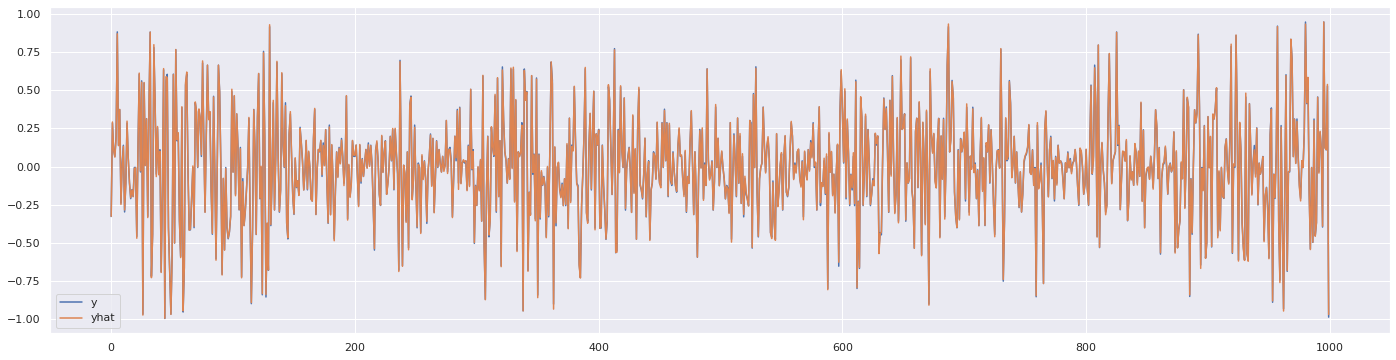

In [191]:
#print(yhat.shape)
#print(yhat)
#print(pd.DataFrame(yhat))
#print(out_valid)
#plt.plot(out_valid[0], label='y' )
plt.plot(out_train[:1000], label='y' )
plt.plot(yhat[:1000], label='yhat' )
plt.legend()
plt.show()

In [192]:
# evaluate model
loss = model.evaluate(in_test, out_test, verbose=1)
print( 'MAE %f:' % loss)

715/715 [==============================] - 0s 533us/sample - loss: 0.3344
MAE 0.334430:


In [193]:
# prediction on new data

yhat = model.predict(in_valid, verbose=0)

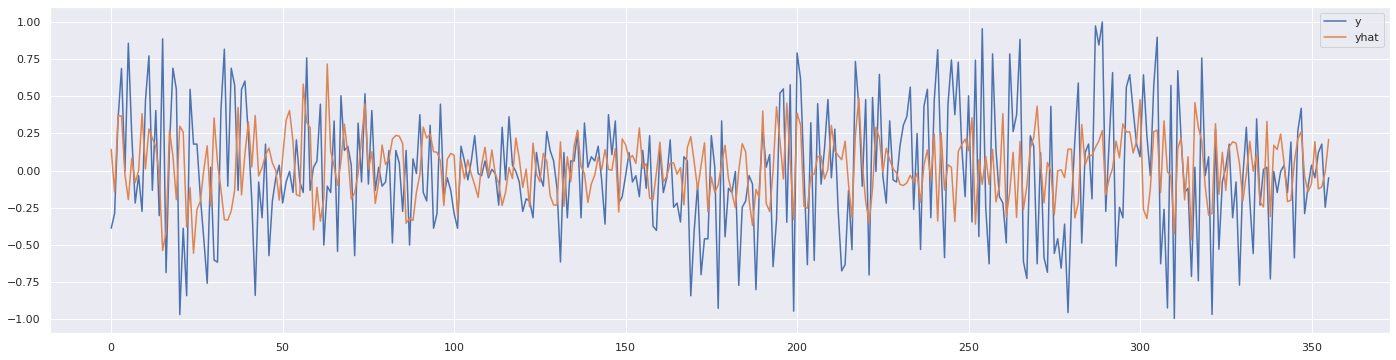

In [194]:
#print(yhat.shape)
#print(yhat)
#print(pd.DataFrame(yhat))
#print(out_valid)
#plt.plot(out_valid[0], label='y' )
plt.plot(pd.DataFrame(out_valid)[0], label='y' )
plt.plot(pd.DataFrame(yhat)[0], label='yhat' )
plt.legend()
plt.show()

In [142]:
ins = ddf2d['bid'][1:].values
outs = ddf2d['bid'].shift()[1:].values
print(ins[:10])
print(outs[:10])

[-2.0e-05 -3.0e-05 -7.0e-05 -1.0e-05 -1.7e-04  2.7e-04 -4.0e-05 -1.0e-04
  0.0e+00  4.0e-05]
[ 1.0e-04 -2.0e-05 -3.0e-05 -7.0e-05 -1.0e-05 -1.7e-04  2.7e-04 -4.0e-05
 -1.0e-04  0.0e+00]


### 2.4.1 Replace the spreads in the differenced data with corresponding maximum spreads during the period

Shift the spreads down by 1 

In [93]:
ddf2a1 = ddf2a
ddf2a1['spread'] = max_spreads#.shift()
print(ddf2a1.head(10))

                         bid      ask   spread
date                                          
2016-01-04 00:05:00  0.00010  0.00006  0.00012
2016-01-04 00:10:00 -0.00002  0.00002  0.00013
2016-01-04 00:15:00 -0.00003 -0.00005  0.00013
2016-01-04 00:20:00 -0.00007 -0.00007  0.00013
2016-01-04 00:25:00 -0.00003 -0.00001  0.00013
2016-01-04 00:30:00 -0.00017 -0.00014  0.00015
2016-01-04 00:35:00  0.00029  0.00029  0.00012
2016-01-04 00:40:00 -0.00002 -0.00007  0.00011
2016-01-04 00:45:00 -0.00012 -0.00010  0.00011
2016-01-04 00:50:00  0.00000  0.00002  0.00011


count    5652.000000
mean        0.000142
std         0.000116
min         0.000080
0%          0.000080
5%          0.000100
10%         0.000110
15.0%       0.000110
20%         0.000110
25%         0.000110
30.0%       0.000110
35%         0.000110
40%         0.000120
45%         0.000120
50%         0.000120
55.0%       0.000130
60.0%       0.000130
65%         0.000130
70%         0.000130
75%         0.000130
80%         0.000140
85.0%       0.000150
90%         0.000160
95%         0.000230
max         0.003770
Name: spread, dtype: float64

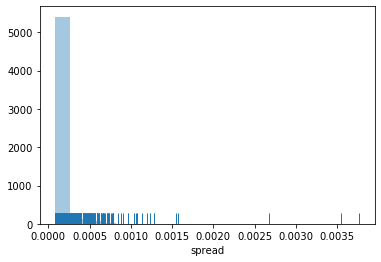

In [116]:
#print(max_spreads.hist(bins=20))
sns.distplot(max_spreads, bins=20, kde=False, rug=True)
max_spreads.describe([.05 * x for x in range(20)])

In [100]:
gains = ddf2a1[abs(ddf2a1['bid']) > ddf2a1['spread']]
print(gains.shape[0], ' out of ', ddf2a1.shape[0], ' equalling ', gains.shape[0]/ddf2a1.shape[0]/.01, '%')

3373  out of  7451  equalling  45.2690913971279 %
